# Exploration of Enron Data

The purpose of this notebook is to explore then Enron email and financial data for the purposes of completeting Udacity's Introduction to Machine Learning course.

In [127]:
# Imports needs to get data
import sys
sys.path.append("./tools/")
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# For Feature selection and Processing
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import StratifiedShuffleSplit, train_test_split

# For parameter tuning
from sklearn.pipeline import Pipeline

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from time import time

In [94]:
features_list = ['poi'] # Add features here

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [95]:
print "We have data on " + str(len(data_dict.keys())) + " people within Enron"

We have data on 146 people within Enron


In [96]:
print 'We have ' + str(len(df[df['poi'] == True])) + ' POIs in our dataset, so it\'s heavily imbalanced.'

We have 18 POIs in our dataset, so it's heavily imbalanced.


We need this class imbalance in mind when evaluating models, as a classification model that simply predicts 'Non-POI' for all cases would be right in 126 cases.

# Outlier Detection

We start our investigation using the salary and bonus figures, as I believe these two figures will either display outliers, or act as latent variables for outliers. For example mistyped figures, or other data-processing errors will likely be captured within these two figures.

We start by simply plotting Salary against Bonus.

In [97]:
def scatter(x, y):
    """
    Function to create scatterplot given x, y points
    """
    features = ["poi", x, y]
    data = featureFormat(data_dict, features)

    for point in data:
        x_points = point[1]
        y_points = point[2]
        plt.scatter(x_points, y_points)

    plt.title(x + ' vs ' + y)
    plt.xlabel(x)
    plt.ylabel(y)
    #plt.figtext(x=0.2, y=0.8, s='From this, we can see that there\'s a large outlier in the top-right hand corner.')
    plt.show()

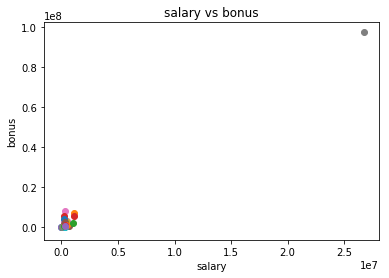

In [98]:
scatter('salary', 'bonus')

That outlier is a bit odd! Let's explore it a bit more below.

In [99]:
# Convert dict to Dataframe
df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN', np.nan)

In [100]:
df.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,9.500000e+01,86.000000,3.900000e+01,1.250000e+02,1.020000e+02,8.200000e+01,1.100000e+02,86.000000,1.800000e+01,1.260000e+02,9.500000e+01,4.000000e+00,86.000000,9.300000e+01,86.000000,1.700000e+01,4.900000e+01,6.600000e+01,86.000000
mean,5.621943e+05,2073.860465,1.642674e+06,5.081526e+06,5.987054e+06,2.374235e+06,2.321741e+06,1176.465116,1.664106e+05,6.773957e+06,1.087289e+05,4.196250e+07,608.790698,9.190650e+05,41.232558,1.668049e+05,-1.140475e+06,1.470361e+06,64.895349
std,2.716369e+06,2582.700981,5.161930e+06,2.906172e+07,3.106201e+07,1.071333e+07,1.251828e+07,1178.317641,4.201494e+06,3.895777e+07,5.335348e+05,4.708321e+07,1841.033949,4.589253e+06,100.073111,3.198914e+05,4.025406e+06,5.942759e+06,86.979244
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,3.285000e+03,7.000000e+04,-2.604490e+06,2.000000,-7.576788e+06,-4.409300e+04,1.480000e+02,4.000000e+05,12.000000,2.000000e+00,0.000000,3.285000e+03,-2.799289e+07,6.922300e+04,0.000000
25%,2.118160e+05,541.250000,8.157300e+04,3.944750e+05,5.278862e+05,4.312500e+05,2.540180e+05,249.750000,-3.896218e+05,4.945102e+05,2.261400e+04,1.600000e+06,22.750000,1.215000e+03,1.000000,9.878400e+04,-6.948620e+05,2.812500e+05,10.000000
50%,2.599960e+05,1211.000000,2.274490e+05,1.101393e+06,1.310814e+06,7.693750e+05,4.517400e+05,740.500000,-1.469750e+05,1.102872e+06,4.695000e+04,4.176250e+07,41.000000,5.238200e+04,8.000000,1.085790e+05,-1.597920e+05,4.420350e+05,35.000000
75%,3.121170e+05,2634.750000,1.002672e+06,2.093263e+06,2.547724e+06,1.200000e+06,1.002370e+06,1888.250000,-7.500975e+04,2.949847e+06,7.995250e+04,8.212500e+07,145.500000,3.620960e+05,24.750000,1.137840e+05,-3.834600e+04,9.386720e+05,72.250000
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,3.117640e+08,9.734362e+07,1.303223e+08,5521.000000,1.545629e+07,4.345095e+08,5.235198e+06,8.392500e+07,14368.000000,4.266759e+07,609.000000,1.398517e+06,-8.330000e+02,4.852193e+07,528.000000


By viewing this, we can see that the Max values are typically a lot higher than the mean, let's explore the Max values a bit more...

In [101]:
df.sort_values(by=['salary'], ascending=False)[:5] # print highest five salary amounts

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
TOTAL,26704229.0,NaN,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,NaN,-7576788.0,434509511.0,...,83925000.0,NaN,42667589.0,NaN,False,1398517.0,-27992891.0,48521928.0,NaN,NaN
SKILLING JEFFREY K,1111258.0,3627.0,NaN,8682716.0,19250000.0,5600000.0,6843672.0,2042.0,NaN,26093672.0,...,NaN,108.0,22122.0,30.0,True,NaN,NaN,1920000.0,jeff.skilling@enron.com,88.0
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,NaN,49110078.0,...,81525000.0,36.0,10359729.0,16.0,True,NaN,-300000.0,3600000.0,kenneth.lay@enron.com,123.0
FREVERT MARK A,1060932.0,3275.0,6426990.0,17252530.0,10433518.0,2000000.0,4188667.0,2979.0,NaN,14622185.0,...,2000000.0,21.0,7427621.0,6.0,False,NaN,-3367011.0,1617011.0,mark.frevert@enron.com,242.0
PICKERING MARK R,655037.0,898.0,NaN,1386690.0,28798.0,300000.0,NaN,728.0,NaN,28798.0,...,400000.0,67.0,NaN,0.0,False,NaN,NaN,NaN,mark.pickering@enron.com,7.0


We can now see that there is a Total Figure that is a lot higher than the other figures. The second highest figure, Is Jeffery Skilling who was the CEO of Enron at the time of the collapse - so it makes sense that he has a high salary (and other financial figures)

Given this findings, it's fair to remove the Total Figure, but keep Jeffery Skilling and below, as these figures make logical sense.

We also notice by taking a look at the POIs in the dataset that there is a business called THE TRAVEL AGENCY IN THE PARK in the dataset. As the purpose of this investigation is to indentify POIs, we'll remove this data point.

In [102]:
df.drop(['TOTAL'], inplace=True)
df.drop(['THE TRAVEL AGENCY IN THE PARK'], inplace=True)

# Drop figures from data_dict as well
data_dict.pop('TOTAL', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

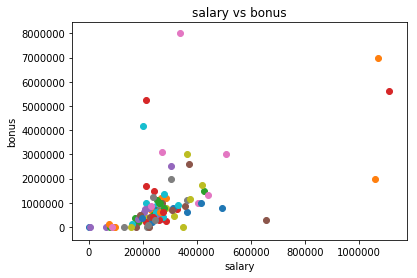

In [103]:
# Re-plot same graph without outlier
scatter('salary', 'bonus')

## Missing Data Exploration

In [104]:
print 'Counts of Null Values'
print '---------------------'
df.isnull().sum()

Counts of Null Values
---------------------


salary                        50
to_messages                   58
deferral_payments            106
total_payments                21
exercised_stock_options       43
bonus                         63
restricted_stock              35
shared_receipt_with_poi       58
restricted_stock_deferred    127
total_stock_value             19
expenses                      50
loan_advances                141
from_messages                 58
other                         53
from_this_person_to_poi       58
poi                            0
director_fees                128
deferred_income               96
long_term_incentive           79
email_address                 33
from_poi_to_this_person       58
dtype: int64

In [105]:
def fill_nan_values():
    """
    Function to replace NaN values.
    Salary = Median Value of salary
    Other NaN values = 0 
    """
    replace_value = df['salary'].median()

    person_key = data_dict.keys()
    feature_key = data_dict[people_keys[0]]
    
    for feature in feauture:
        nan_features[feature] = 0
        
    for person in people_key:
        for feature in feature_key:
            if feature != 'email_address' and feature != 'salary' and \
                data_dict[person][feature] == 'NaN':
                data_dict[person][feature] = 0

            elif feature == 'salary' and feature != 'email_address' and \
            data_dict[person][feature] == 'NaN':
                data_dict[person][feature] = replace_value

# Feature Creation and Pre-processing
## Feature Creation
Taking a look at the data, and reviewing course material, there is really only one feature that I want to create. The following feature is the ratio of:

$$ total_to / from_this_person_to_poi

In [106]:
for key in data_dict:
    # Create from_ratio. Set from_ratio to zero if NaN appears
    if (data_dict[key]['from_this_person_to_poi'] == 'NaN') or (data_dict[key]['from_messages'] == 'NaN'):
        data_dict[key]['from_ratio'] = 0.0
    else:
        data_dict[key]['from_ratio'] = (1.0*data_dict[key]['from_this_person_to_poi']/data_dict[key]['from_messages'])
    # Create to_ratio. set to_ratio to zero if NaN appears
    if (data_dict[key]['from_poi_to_this_person']=='NaN') or (data_dict[key]['to_messages']=='NaN'):
          data_dict[key]['to_ratio'] = 0.0
    else:  
        data_dict[key]['to_ratio'] = (1.0*data_dict[key]['from_poi_to_this_person']/data_dict[key]['to_messages']) 

In [107]:
features_list = ["poi", "salary", "bonus", 'deferral_payments', 'total_payments', 'loan_advances', 
                 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                 'exercised_stock_options', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 
                 'director_fees', 'from_ratio', 'to_ratio'] # add new features to dataset
data = featureFormat(data_dict, features_list)

In [143]:
### Split Training/Test datasets

labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            labels,
                                                                            test_size=0.1,
                                                                            random_state=42)

In [144]:
scaler = MinMaxScaler()
features_train = scaler.fit_transform(features_train)
featues_test = scaler.fit_transform(features_test)

## Feature Selection

For the feature selection, I'm going to use sklearn's select k-best feautures.

In [145]:
skbest = SelectKBest(k=10)
sk_transform = skbest.fit_transform(features_train, labels_train)
indices = skbest.get_support(True)

In [146]:
best_list = ['poi']
for index in indices:
    print 'features: %s score: %f' % (features_list[index + 1], skbest.scores_[index])
    best_list.append(features_list[index + 1])

features: salary score: 5.681545
features: bonus score: 3.707765
features: deferred_income score: 8.184312
features: total_stock_value score: 10.259559
features: expenses score: 4.694982
features: exercised_stock_options score: 11.284944
features: long_term_incentive score: 3.513005
features: director_fees score: 1.831547
features: from_ratio score: 12.569123
features: to_ratio score: 3.063668


# Model Building

The purpose of this investigation is to build a model to identify Persons of Interest. In this particular case, we have labelled data as to whether the person is a Person of Interest or not. Since we have labelled data we're trying to solve a supervised learning problem using classification techniques.

We know from the previous section of this report, that we have a list of the 10 best features to use in models. These are:

In [147]:
best_list

['poi',
 'salary',
 'bonus',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'long_term_incentive',
 'director_fees',
 'from_ratio',
 'to_ratio']

The models we're going to be using are the following:

* Naive Bayes (as a baseline)
* Random Forest Classitfication
* K Nearest Neighbors Classification

All of the above models will include parameter tuning where possible.

In [148]:
# Import models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
# Metric for evaluation.
from sklearn.metrics import accuracy_score
# Import Gridsearch for hyper-paramater tuning
from sklearn.model_selection import GridSearchCV

# Baseline Models (No parameter tuning)
### Support Vector Classification

In [149]:
# Support Vector Classification
clf = AdaBoostClassifier()
clf.fit(features_train, labels_train)
clf.score(features_test, labels_test)

0.73333333333333328

### K-Nearest Neighbors Classification

In [150]:
clf = KNeighborsClassifier()
clf.fit(features_train, labels_train)
clf.score(features_test, labels_test)

0.73333333333333328

### Decision Tree

In [151]:
clf = DecisionTreeClassifier()
clf.fit(features_train, labels_train)
clf.score(features_test, labels_test)

0.20000000000000001

## Parameter Tuning

The alogorithims above are simply run using the default paramters. It is generally believed, that we should get better performance from the algorithim by tuning the parameters.

One other thing that is sitting uncomfortably with me, is we arbitarily set the feature selection to be 10 features. But we're trying three different algorithims, perhaps 10 features aren't good for some of these models? So to combat this, we're going also play around with the number of features.

In [152]:
shuffle = StratifiedShuffleSplit(labels, 500, test_size=0.45, random_state=42)

In [153]:
select_best = SelectKBest(k=10)
clf = KNeighborsClassifier()

steps = [('feature_selection', select_best),
        ('model', clf)]

pipeline = Pipeline(steps)

In [155]:
parameters = dict(feature_selection__k = [3, 5, 7, 9, 11, 12, 15], 
              model__n_neighbors = [2, 3, 4, 5, 6, 7],
              model__metric = ['euclidean', 'minkowski'])

cv = GridSearchCV(pipeline, param_grid=parameters, scoring='f1', cv=shuffle)

cv.fit(features, labels)
predictions = cv.predict(features_test)
report = sklearn.metrics.classification_report(labels_test, predictions)
print report
print '\n'
print cv.best_params_

             precision    recall  f1-score   support

        0.0       0.85      1.00      0.92        11
        1.0       1.00      0.50      0.67         4

avg / total       0.89      0.87      0.85        15



{'model__metric': 'euclidean', 'feature_selection__k': 9, 'model__n_neighbors': 3}


In [ ]:
select_best_ada = SelectKBest(k=10)
clf_ada = AdaBoostClassifier()

steps = [('feature_selection', select_best_ada),
        ('model', clf_ada)]

pipeline_ada = sklearn.pipeline.Pipeline(steps)

In [ ]:
parameters = dict(feature_selection__k = [3, 5, 7, 9, 11, 12, 15], 
              model__n_estimators = [40, 50, 60, 70, 80, 90])

cv = GridSearchCV(pipeline_ada, param_grid=parameters, scoring='f1', cv=shuffle)

cv.fit(features, labels)
predictions = cv.predict(features_test)
report = sklearn.metrics.classification_report(labels_test, predictions)
print report
print '\n'
print cv.best_params_